# Reproducing Seok et al. paper: "Poorly mimics"

### Setup

In [21]:
import os
import numpy as np
import pandas as pd
import anndata as ad
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, ttest_ind

load_dotenv()

True

In [22]:
DATA_DIR = os.getenv("INFLAMM_DEBATE_FM_DATA_ROOT")
ANN_DATA_DIR = os.path.join(DATA_DIR, "processed/anndata_cleaned/")

# Load data
adatas = {}
for f in sorted(os.listdir(ANN_DATA_DIR)):
    if f.endswith(".h5ad"):
        name = f.replace(".h5ad", "")
        path = os.path.join(ANN_DATA_DIR, f)
        adatas[name] = ad.read_h5ad(path)
        print(f"Loaded {name}: {adatas[name].shape}")
adatas

Loaded human_burn: (590, 19914)
Loaded human_sepsis: (30, 19914)
Loaded human_trauma: (857, 19914)
Loaded mouse_burn: (32, 13832)
Loaded mouse_infection: (72, 10248)
Loaded mouse_sepsis: (50, 13832)
Loaded mouse_trauma: (96, 13832)


{'human_burn': AnnData object with n_obs × n_vars = 590 × 19914
     obs: 'group', 'patient_id', 'tissue', 'sex', 'age', 'time_point_hours', 'takao_inflamed', 'takao_control', 'takao_status', 'infl_acute', 'infl_subacute', 'infl_chronic'
     var: 'ensembl', 'symbol',
 'human_sepsis': AnnData object with n_obs × n_vars = 30 × 19914
     obs: 'tissue', 'group', 'takao_inflamed', 'takao_control', 'takao_status'
     var: 'ensembl', 'symbol',
 'human_trauma': AnnData object with n_obs × n_vars = 857 × 19914
     obs: 'group', 'patient_id', 'tissue', 'sex', 'age', 'time_point_hours', 'takao_inflamed', 'takao_control', 'takao_status', 'infl_acute', 'infl_subacute', 'infl_chronic'
     var: 'ensembl', 'symbol',
 'mouse_burn': AnnData object with n_obs × n_vars = 32 × 13832
     obs: 'title', 'cell_type', 'sex', 'strain', 'time_point_hours', 'group', 'patient_id', 'takao_inflamed', 'takao_control', 'takao_status', 'infl_acute', 'infl_subacute', 'infl_chronic'
     var: 'ensembl', 'symbol',
 '

### Recreate figure 1

In [23]:
def compute_metrics(fc_x, fc_y):
    r, _ = pearsonr(fc_x, fc_y)
    r2 = r**2
    same_direction = (fc_x * fc_y > 0).sum()
    percent_same = same_direction / len(fc_x) * 100 if len(fc_x) > 0 else np.nan
    rho, _ = spearmanr(fc_x, fc_y)
    return {
        "R2_Pearson": r2,
        "Percent_Same_Direction": percent_same,
        "Spearman_rho": rho
    }

def plot_metrics_text(ax, metrics):
    text = (
        f"ρ = {metrics['Spearman_rho']:.2f}\n\n"
        f"%Dir = {metrics['Percent_Same_Direction']:.1f}\n"
        f"R² = {metrics['R2_Pearson']:.2f}"
    )
    ax.text(0.5, 0.5, text, ha="center", va="center", fontsize=24)
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)

def plot_scatter_fc(ax, fc_x, fc_y):
    ax.scatter(fc_x, fc_y, s=10, alpha=0.5, edgecolor="none")
    lims = [min(fc_x.min(), fc_y.min()), max(fc_x.max(), fc_y.max())]
    ax.plot(lims, lims, color="red", lw=1)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    for spine in ax.spines.values():
        spine.set_visible(True)

def get_fc_vectors(dataset_i, dataset_j, sig_genes, fc_key="FCmax"):
    """
    Return aligned FC vectors for dataset_i and dataset_j, filtered to sig_genes.
    Expects each AnnData.var to contain a column `fc_key` with log2 FC per gene.
    """
    adata_i, adata_j = dataset_i, dataset_j

    # Intersection of sig_genes and genes present in both datasets
    genes = list(set(sig_genes) & set(adata_i.var_names) & set(adata_j.var_names))
    if not genes:
        return np.array([]), np.array([]), 0

    fc_i = adata_i.var.loc[genes, fc_key].astype(float).to_numpy()
    fc_j = adata_j.var.loc[genes, fc_key].astype(float).to_numpy()

    return fc_i, fc_j, len(genes)


def make_comparison_grid(datasets_dict, sig_genes, fc_key="FCmax"):
    """
    Recreate Seok-style FC comparison grid.
    - Diagonal: dataset names
    - Upper triangle: metrics (ρ, R², % same direction)
    - Lower triangle: scatter plots
    """
    dataset_names = [
        "human_burn", "human_trauma", "human_sepsis",
        "mouse_burn", "mouse_trauma", "mouse_sepsis", "mouse_infection"
    ]
    n = len(dataset_names)
    fig, axes = plt.subplots(n, n, figsize=(3*n, 3*n))

    # Precompute FC vectors (to avoid recomputing repeatedly)
    fc_vectors = {}
    for i, name_i in enumerate(dataset_names):
        for j, name_j in enumerate(dataset_names):
            if j < i:
                fc_vectors[(i, j)] = fc_vectors[(j, i)]
            else:
                vectors = get_fc_vectors(
                    datasets_dict[name_i],
                    datasets_dict[name_j],
                    sig_genes=sig_genes,
                    fc_key=fc_key
                )
                print(f"[INFO] FC vectors for {name_i} vs {name_j}: n_genes={vectors[2]}")
                fc_vectors[(i, j)] = vectors

    # Diagonal: dataset names
    for i, name in enumerate(dataset_names):
        ax = axes[i, i]
        ax.text(0.5, 0.5, name.replace("_", " "), ha="center", va="center",
                fontsize=16, fontweight="bold")
        ax.set_xticks([]); ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(True)

    # Upper triangle: metrics
    for i in range(n):
        for j in range(i+1, n):
            ax = axes[i, j]
            fc_i, fc_j, n_genes = fc_vectors[(i, j)]
            if n_genes > 0:
                metrics = compute_metrics(fc_i, fc_j)
                plot_metrics_text(ax, metrics)
            else:
                ax.text(0.5, 0.5, "No overlap", ha="center", va="center")
            ax.set_xticks([]); ax.set_yticks([])

    # Lower triangle: scatter
    for i in range(1, n):
        for j in range(i):
            ax = axes[i, j]
            fc_i, fc_j, n_genes = fc_vectors[(i, j)]
            if n_genes > 0:
                plot_scatter_fc(ax, fc_i, fc_j)
            else:
                ax.text(0.5, 0.5, "No overlap", ha="center", va="center")
            ax.set_xticks([]); ax.set_yticks([])

    plt.tight_layout()
    return fig


In [25]:
def takao_de_to_var(adata, fc_thresh=1.2, alpha=0.05):
    """
    Compute Takao-style differential expression and store results in adata.var.
    
    Parameters
    ----------
    adata : AnnData
        AnnData object (samples x genes), assumed log2-normalized.
    fc_thresh : float, default=1.2
        Fold-change threshold (linear scale; Takao used 1.2 for mice, 2.0 for humans).
    alpha : float, default=0.05
        P-value threshold.

    Returns
    -------
    AnnData
        Same object with new columns in .var:
        - f"{prefix}_logfc" : mean log2 fold change
        - f"{prefix}_fc" : Takao-style linear fold change (signed with reciprocal transform)
        - f"{prefix}_pval" : t-test p-values
        - f"{prefix}_sig" : significance flag
    """
    inflamed_mask = adata.obs["takao_status"] == "takao_inflamed"
    control_mask  = adata.obs["takao_status"] == "takao_control"

    X = np.asarray(adata.X)
    inflamed = X[inflamed_mask, :]
    control  = X[control_mask, :]

    inflamed_mean = inflamed.mean(axis=0)
    control_mean  = control.mean(axis=0)

    # log2 fold change
    logfc = inflamed_mean - control_mean

    # convert back to linear fold change
    fc = 2 ** logfc

    # Takao transform
    takao_fc = np.where(fc >= 1, fc, -1.0 / (fc + 1e-8))

    # two-sample t-tests on log2 values (as NextBio likely did)
    t_res = ttest_ind(inflamed, control, axis=0, equal_var=False, nan_policy="omit")
    pvals = t_res.pvalue

    sig = (np.abs(takao_fc) > fc_thresh) & (pvals < alpha)

    adata.var["logfc"] = logfc
    adata.var["fc"]    = takao_fc
    adata.var["pval"]  = pvals
    adata.var["sig"]   = sig

    return adata

In [26]:
sig_adatas = {k: takao_de_to_var(v, fc_thresh=2.0, alpha=0.05) for k, v in adatas.items() if k in ["human_burn", "human_trauma", "human_sepsis"]}
sig_adatas = {**sig_adatas, **{k: takao_de_to_var(v, fc_thresh=1.2, alpha=0.05) for k, v in adatas.items() if k in ["mouse_burn", "mouse_trauma", "mouse_sepsis", "mouse_infection"]}}

In [30]:
# get the union of significant genes in human_burn and human_trauma and human_sepsis
sig_burn = sig_adatas["human_burn"].var[sig_adatas["human_burn"].var["sig"]].index
sig_trauma = sig_adatas["human_trauma"].var[sig_adatas["human_trauma"].var["sig"]].index
sig_sepsis = sig_adatas["human_sepsis"].var[sig_adatas["human_sepsis"].var["sig"]].index
union_genes = pd.Index(np.unique(np.concatenate([sig_burn, sig_trauma, sig_sepsis])))

sig_genes = union_genes.tolist()
print(f"Number of sig_genes: {len(sig_genes)}")

Number of sig_genes: 1672


[INFO] FC vectors for human_burn vs human_burn: n_genes=1672
[INFO] FC vectors for human_burn vs human_trauma: n_genes=1672
[INFO] FC vectors for human_burn vs human_sepsis: n_genes=1672
[INFO] FC vectors for human_burn vs mouse_burn: n_genes=1201
[INFO] FC vectors for human_burn vs mouse_trauma: n_genes=1201
[INFO] FC vectors for human_burn vs mouse_sepsis: n_genes=1201
[INFO] FC vectors for human_burn vs mouse_infection: n_genes=977
[INFO] FC vectors for human_trauma vs human_trauma: n_genes=1672
[INFO] FC vectors for human_trauma vs human_sepsis: n_genes=1672
[INFO] FC vectors for human_trauma vs mouse_burn: n_genes=1201
[INFO] FC vectors for human_trauma vs mouse_trauma: n_genes=1201
[INFO] FC vectors for human_trauma vs mouse_sepsis: n_genes=1201
[INFO] FC vectors for human_trauma vs mouse_infection: n_genes=977
[INFO] FC vectors for human_sepsis vs human_sepsis: n_genes=1672
[INFO] FC vectors for human_sepsis vs mouse_burn: n_genes=1201
[INFO] FC vectors for human_sepsis vs mouse

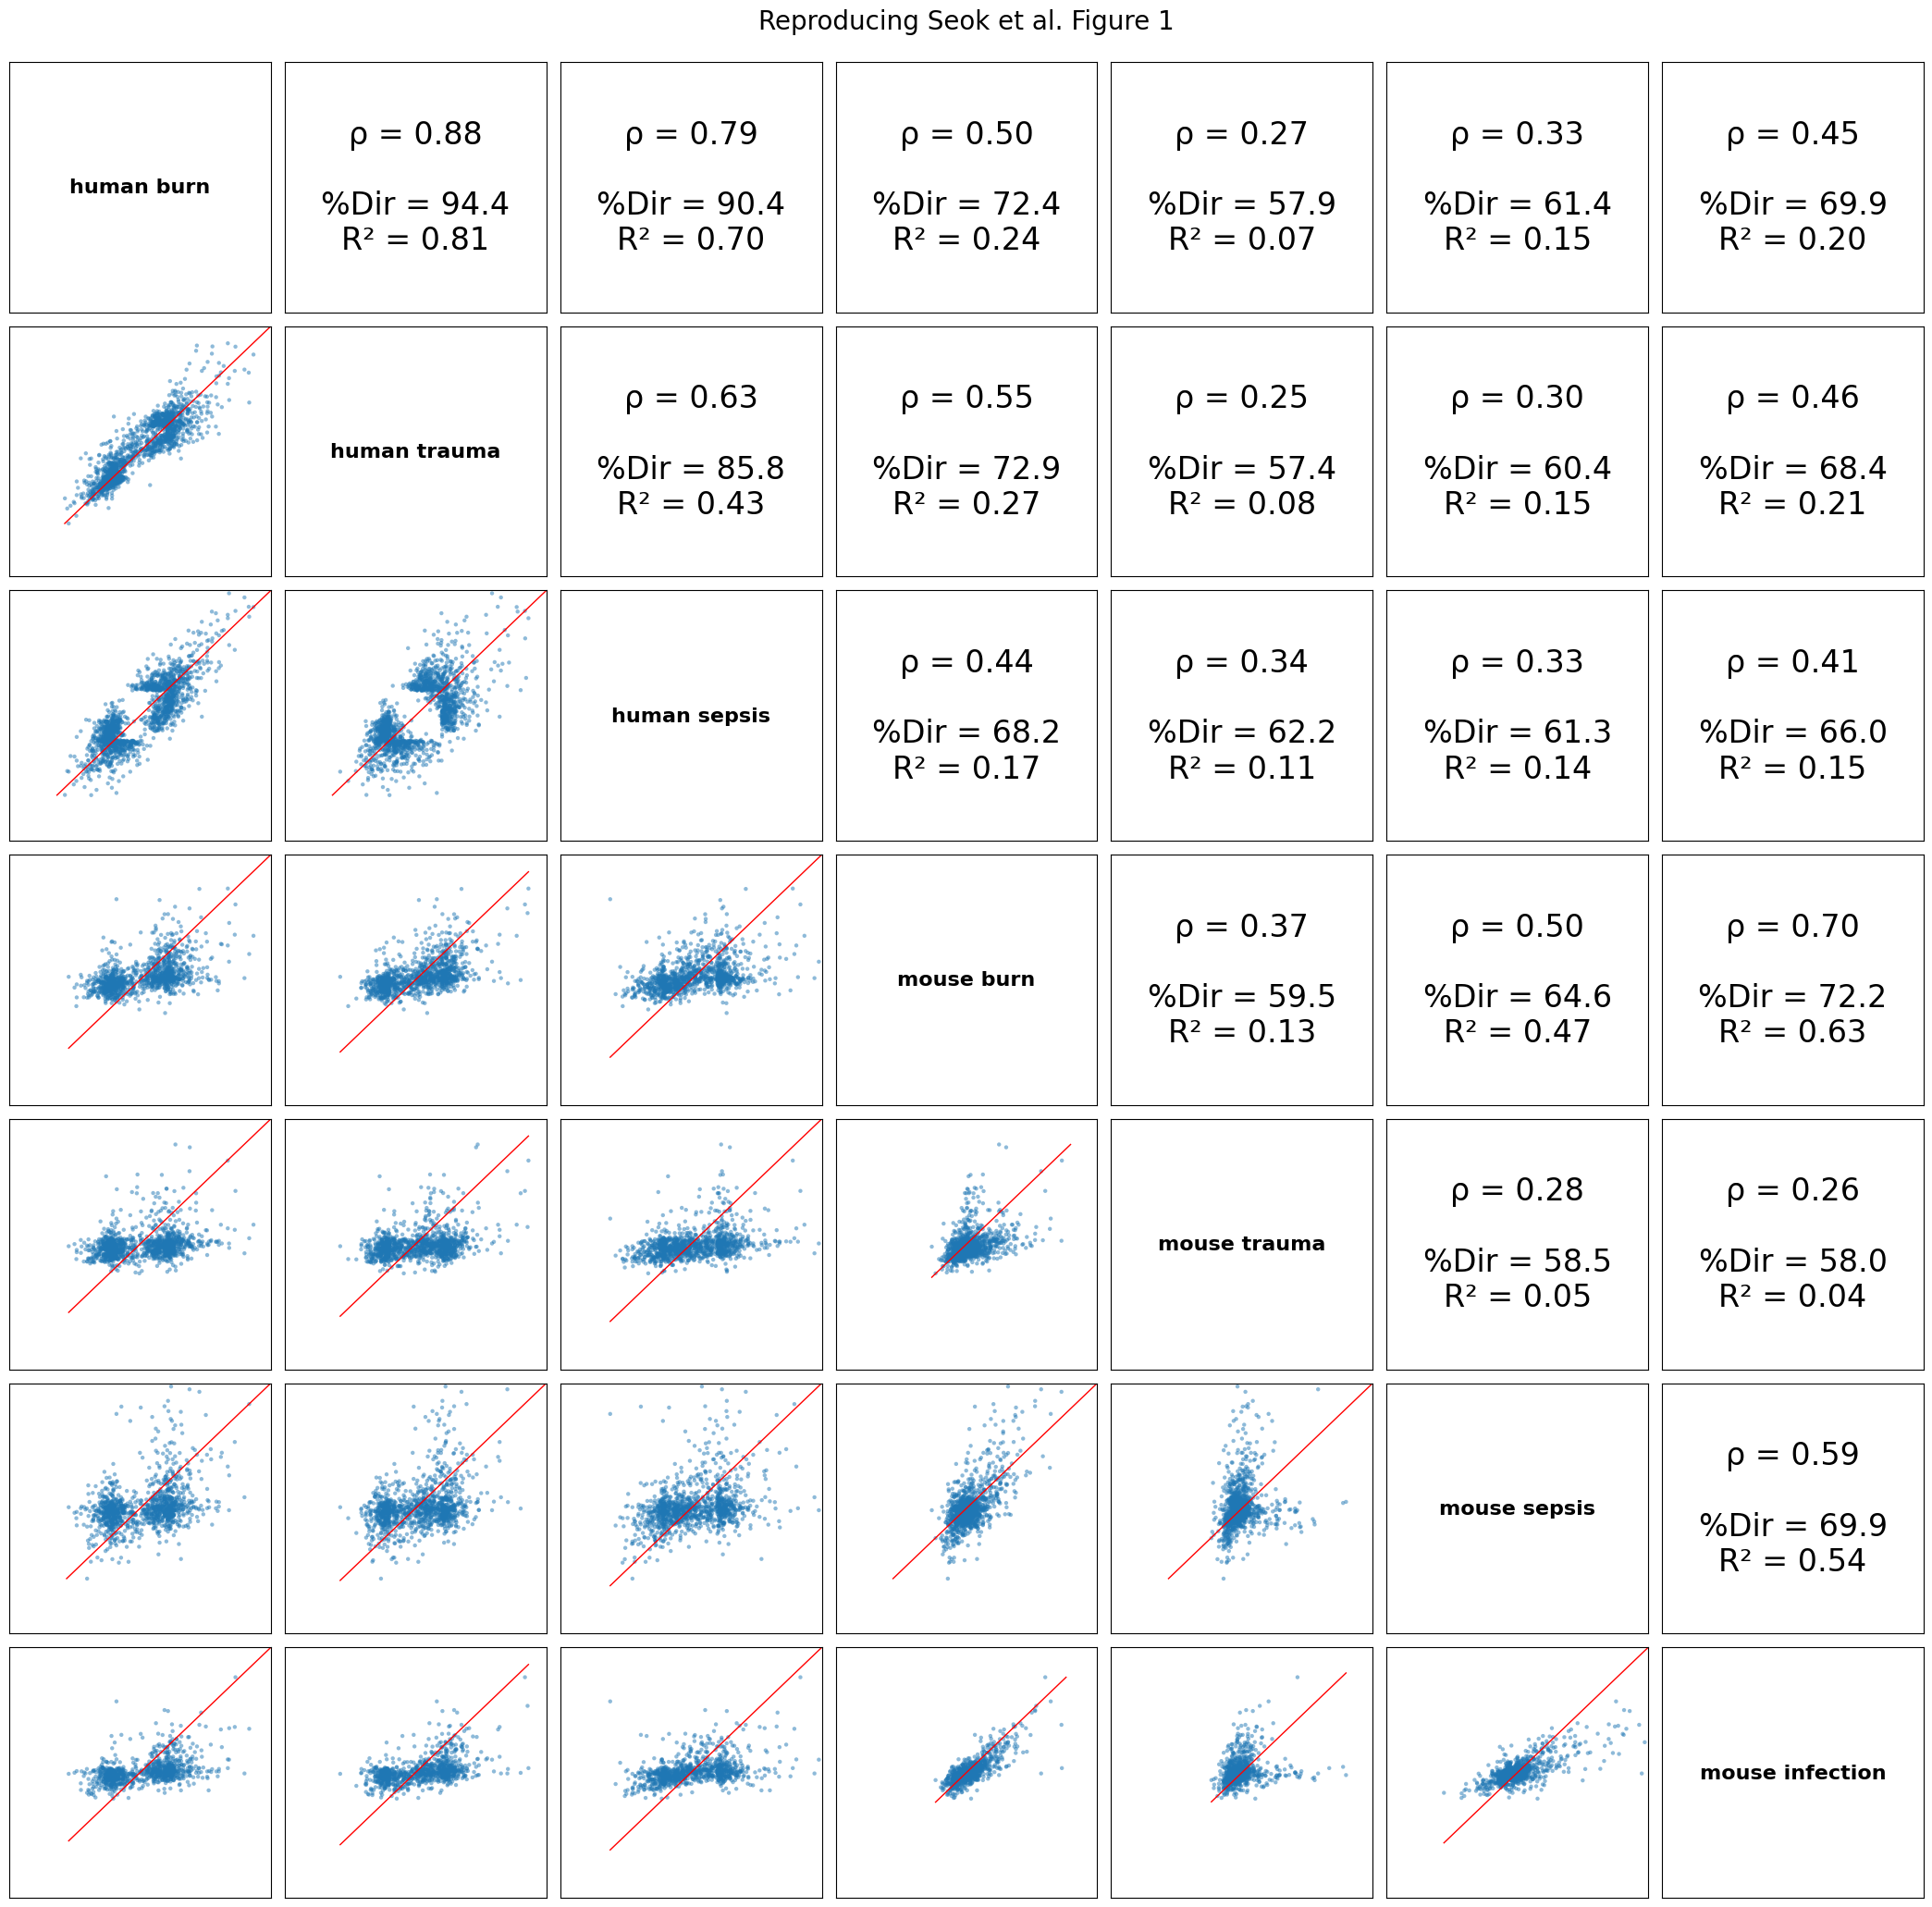

In [36]:
fig = make_comparison_grid(sig_adatas, sig_genes, fc_key="logfc")
fig.suptitle("Reproducing Seok et al. Figure 1", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()